In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from itertools import count
from generate_solar_data import plot_points
from helper_functions import *
from regional_mapper import *
import os
import random
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams.update({'font.size': 19})

# <center> Overview </center>
The first phase of this project was to download solar and wind data for multiple random locations across the Netherlands using the Renewable Ninja API.
#### Data description
I have downloaded hourly data from 2018 to 2019 for the wind and energy generation profiles, the locations of can be seen below
- For the wind data, the Renewables Ninja model uses the *Vestas V80/2000* which has a capacity of 1000kW. The output gives the capacity factor as a percentage of that 1000kW depending on the given weather conditions at that hour
- For the solar data the Renewables Ninja model assumes a capacity of 1 kW and a system loss of 10%.


In [27]:
## Looking at data over the course of the year:
def plot_yearly_data():
    fig, ax = plt.subplots(nrows=3, ncols = 6, figsize = (28,12))
    axs = ax.ravel()

    for i in range(len(axs)): 
        wind_df = parse_data("./winddata/"+os.listdir("./winddata")[i])
        solar_df = parse_data("./pvdata/"+os.listdir("./pvdata")[i])

        wind_df.rolling(720).mean().plot(ax =axs[i], label = 'Wind Data')
        solar_df.rolling(720).mean().plot(ax =axs[i], label = 'Solar Data')
        
        axs[i].legend(['Wind Data','Solar Data'])
        axs[i].set_xlabel("")
        if i != 0:
            axs[i].legend().set_visible(False)
        # axs[i].axes.xaxis.set_visible(False)
        axs[i].set_title("Location = {}, {}".format(get_coordinates("./winddata")[i][0], get_coordinates("./winddata")[i][1]))
    fig.tight_layout()

### **Daily Analysis**
The complimentarity of the solar and wind profiles can be explored on a yearly and daily level. Below I look at daily complimentarity

c:\Users\joshb\Desktop\Energy Projects\Vattenfall Hybrid Park Modelling\VT Energy Modelling\helper_functions.py:34: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['woy'] = df.index.weekofyear


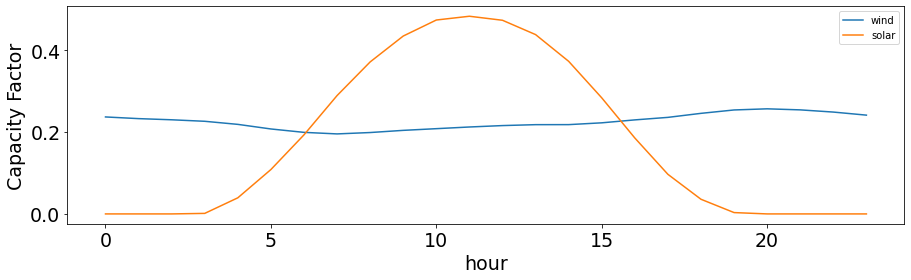

In [18]:
## Looking at daily patterns of data

df_wind = parse_data("./winddata/"+os.listdir("./winddata")[0])
df_wind = make_datetime(df_wind)
df_solar = parse_data("./pvdata/"+os.listdir("./pvdata")[0])
df_solar = make_datetime(df_solar)

def plot_av_daily_trend(df, ax):
    df.pivot_table(index='hour', 
                   values='electricity',
                   aggfunc='mean').plot(ax=ax).plot(ax=ax)


fig, ax = plt.subplots(figsize=(15,4))
plot_av_daily_trend(df_wind, ax)
plot_av_daily_trend(df_solar, ax)
ax.legend(['wind','solar'],prop = {'size':10})
ax.set_ylabel('Capacity Factor')
plt.savefig("./Plots/AvDailyTrends.png", dpi=300)

It appears as though there is limited complimentarity between the average daily profiles. However there are some interesting observations
- Wind has a fairly flat profile: Is this an issue with the way the data is being aggregated? -If we look at a particular season (i.e. winter) is the average profile the same?
- A single wind turbine has a significantly larger power output than a single solar panel, hence even a slight variation in capacity factor will result in a much larger generated power output.

c:\Users\joshb\Desktop\Energy Projects\Vattenfall Hybrid Park Modelling\VT Energy Modelling\helper_functions.py:34: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['woy'] = df.index.weekofyear


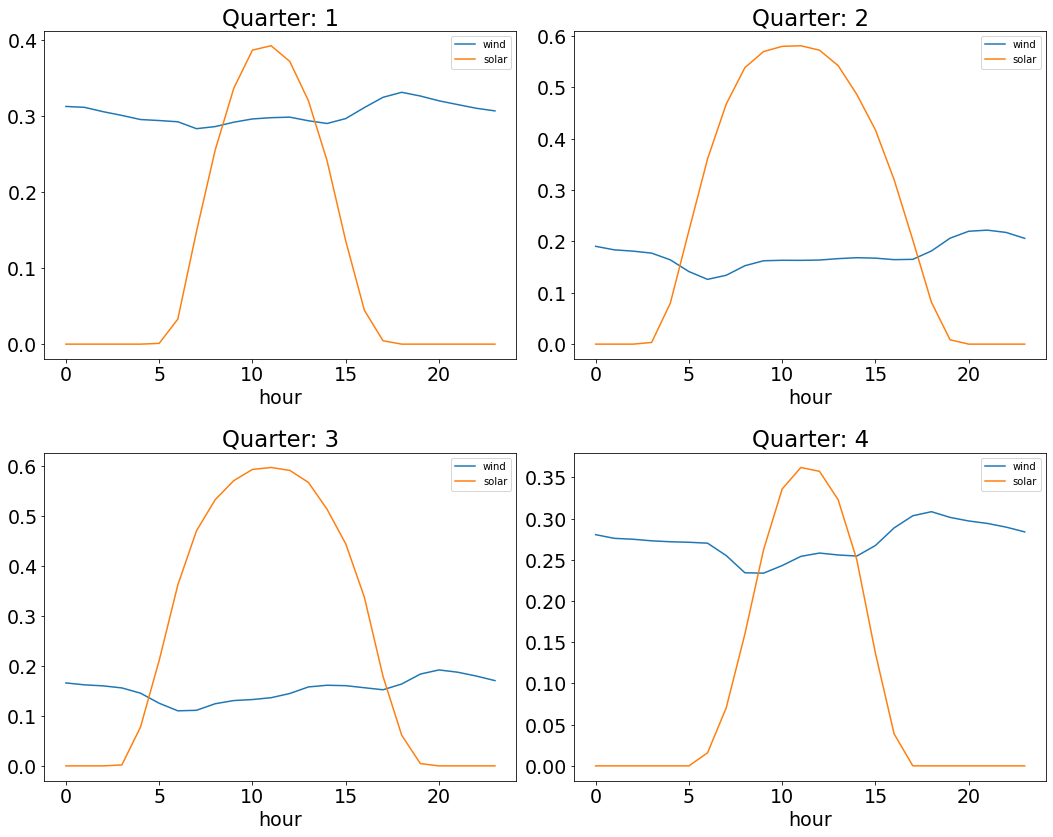

In [22]:
df_wind = parse_data("./winddata/"+os.listdir("./winddata")[0])
df_wind = make_datetime(df_wind)

fig, ax = plt.subplots(2,2, figsize=(15,12))
axs = ax.ravel()
for i, ax in enumerate(axs):
    df_wind_subset = df_wind[df_wind.quarter == i+1]
    plot_av_daily_trend(df_wind_subset, ax)
    df_pv_subset = df_solar[df_solar.quarter == i+1]
    plot_av_daily_trend(df_pv_subset, ax)    
    ax.legend(['wind','solar'],prop = {'size':10})
    ax.set_title("Quarter: {}".format(i+1))
fig.tight_layout()

What is also noticeable is that the profiles shift from summer to winter for both solar and wind, but still the wind CF profile is relatively straight

### **Yearly Analysis** 
The next task is to analysze yearly wind and solar power profiles and assess the complementarity between both over this longer timescale

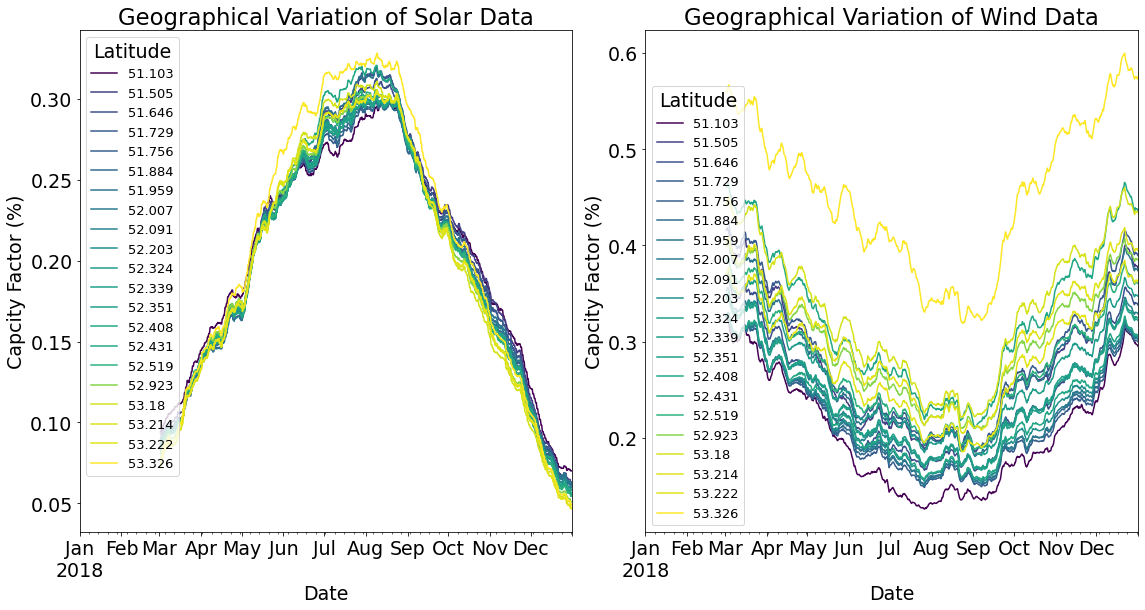

In [28]:
def geographic_variation_plot(directory_name, title, save_name, ax):
    coordinates = get_coordinates(directory_name)
    norm = mpl.colors.Normalize(vmin=coordinates[0][0], vmax=coordinates[-1][0])
    colors = plt.cm.viridis([norm(coord[0]) for coord in coordinates])
    # colors
    for i in range(len(os.listdir(directory_name))):
        df = parse_data(directory_name+os.listdir(directory_name)[i])
        df.rolling(1440).mean().plot(ax =ax, c =colors[i])  # Make the data rolling to reduce short term fluctuations
        ax.legend([coord[0] for coord in coordinates], prop={'size': 13}, title = 'Latitude')
        ax.set_xlabel('Date')
        ax.set_ylabel('Capcity Factor (%)')
    ax.set_title(title)

fig, ax = plt.subplots(1,2, figsize = (16,8))
plt.savefig("Solar&Wind.png", dpi = 300)
fig.tight_layout()

geographic_variation_plot("./pvdata/", 
                          "Geographical Variation of Solar Data", 
                          "./Plots/PVGeographicalVariation.png", 
                          ax =ax[0])
geographic_variation_plot("./winddata/", 
                          "Geographical Variation of Wind Data", 
                          "./Plots/WindGeographicalVariation.png", 
                          ax[1])

We can see this regional variation in wind distribution below. The best region for wind power "Groningen" receives the highest average capacity factor of around 60%

In [29]:
province_path = os.path.join('NL_provinces','provinces.geojson')
map_regional_data(province_path,
                    get_averages('./winddata/'),
                    'WindCapacityPlot.html')

Looking between 2018 and 2019 I notice the following:
1. Significant variation of wind generation deoending on the latitude, with locations more north having significantly more potential to capture wind power
2. Strong complementarity between wind and solar. The wind farm fluctuates from an average maximum CF of 40% in winter to 25% in summer. While the solar data fluctuates from a minimum of 5% CF in winter to 30% in summer.

## Complimentarity
I will analyze the second point in more detail to address just how much complementarity exist between the two. If I look at one of the point locations, I will further analyze how complementary these profiles are.

Complimentarity can be defined in many ways, but for the purpose of this project, I will consider complimentarity as being how *flat* the overall generation profile is when adding the solar power to the wind power.
Below I measure the complementarity by considering a mixture of wind turbines and solar panels on a given hybrid park, it can be seen that as we vary the number of solar panels and wind turbines, the complimentarity changes. What is the sweet spot?

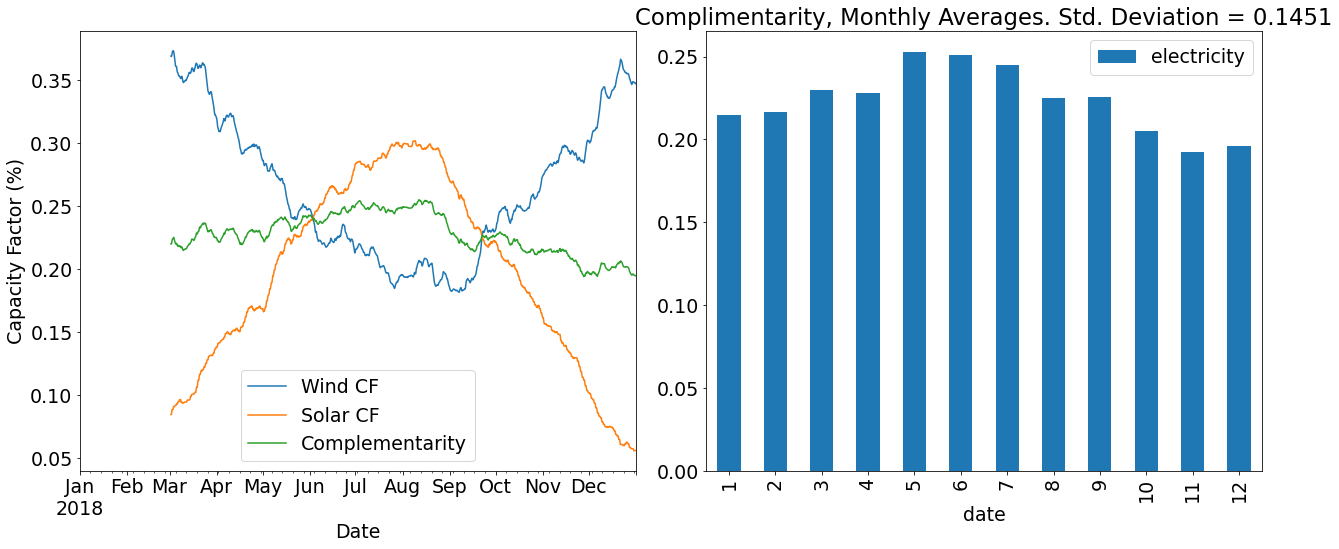

In [30]:
def plot_complementarity(fig, ax, num_wind_turbines=1, num_solar_panels=10):
    df_wind = parse_data("./winddata/winddata_52.324_5.600.csv")
    df_pv = parse_data("./pvdata/pvdata_52.324_5.600.csv")
    df_wind.rolling(1440).mean().plot(ax=ax[0])  # Make the data rolling to reduce short term fluctuations
    df_pv.rolling(1440).mean().plot(ax=ax[0])  # Make the data rolling to reduce short term fluctuations
    df_complementarity = ((1000*num_wind_turbines*df_wind+1*num_solar_panels*df_pv)/(1000*num_wind_turbines+1*num_solar_panels))
    df_complementarity.rolling(1440).mean().plot(ax=ax[0])
    ax[0].legend(["Wind CF", "Solar CF", "Complementarity"])
    month_vals = measure_stationarity(df_complementarity)
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Capacity Factor (%)')
    month_vals.plot.bar(ax = ax[1])
    ax[1].set_title("Complimentarity, Monthly Averages. Std. Deviation = {:.4f}".format(df_complementarity.std()['electricity']))
    fig.tight_layout()

def measure_stationarity(df):
    df = df.groupby(by=[df.index.month])
    mean = df.mean()
    return mean

fig, ax = plt.subplots(1,2, figsize = (18,8))

plot_complementarity(fig, ax, num_wind_turbines=1, num_solar_panels=1100)

Looking into the complimentarity with a bit more detail, what is the perfect number of solar panels and wind turbines that optimizes the complimentarity?
Some simple optimization can answer this question.
The optimization problem can be written as follows:
We wish to find the number of turbines $n_{t}$ and the number fo solar panels $n_{s}$ in order to minimize $$Var(\frac{n_{t}{P_{t}*DF_{t}+P_{s}n_{s}*DF_{s}}}{n_{t}{P_{t}+P_{s}*n_{s}}})$$
Where $P_{t}$ is the power produced per turbine (1000 kW) and $P_{s}$ is the power produced per solar panel (1kW). $DF_{s}$ is the timeseries represenmting the capacity factor of the solar panmel throughout the year and $DF_{t}$ is the same but for the turbine.

To limit the problem i will set the following constraints: $1<=n_{t}<=7$ and $1<=n_{s}<=8000$ 

The above optimization equation can be manipulated through statistics to give the following:
$$\frac{1}{(P_{t}n_{t}+P_{s}n_{s})^2}*\big((P_{t}n_{t})^2*Var(DF_{t})+(P_{s}n_{s})^2*Var(DF_{s})+2*P_{s}P_{t}n_{s}n_{t}Cov(DF_{s},DF_{t})\big)$$

The only variables here are $n_{t}$ and $n_{s}$


In [3]:
P_t = 1000
P_s = 1
df_turbine = pd.Series(parse_data("winddata\winddata_51.729_4.067.csv")['electricity'])
df_solar = pd.Series(parse_data("pvdata/pvdata_51.729_4.067.csv")['electricity'])
cov_df = df_turbine.cov(df_solar)
var_df_t = df_turbine.var()
var_df_s = df_solar.var()
print(" The constants  are the following. P_t = {}, P_s = {}, var_df_t = {}, var_df_s = {}, cov_df = {}".format(P_t,P_s,var_df_t, var_df_t, cov_df))


 The constants  are the following. P_t = 1000, P_s = 1, var_df_t = 0.05043346514504846, var_df_s = 0.05043346514504846, cov_df = -0.011218219945981194


A simple visual analysis will suffice to explore the minimum variance:
Velow we can see that there are clear minimums that arise while varying the number of turbines.
The ratio 1:820 (turbines to solar panels) appears to produce an overall capacity factor with the least variation

To acheive minimum variance of farm for a farm with 1 turbines requires 818 solar panels, (min val = 0.022679397551111067)
To acheive minimum variance of farm for a farm with 2 turbines requires 1637 solar panels, (min val = 0.022679397551111067)
To acheive minimum variance of farm for a farm with 3 turbines requires 2455 solar panels, (min val = 0.022679396953105797)
To acheive minimum variance of farm for a farm with 4 turbines requires 3274 solar panels, (min val = 0.02267939684189815)
To acheive minimum variance of farm for a farm with 5 turbines requires 4093 solar panels, (min val = 0.022679396858618778)
To acheive minimum variance of farm for a farm with 6 turbines requires 4912 solar panels, (min val = 0.022679396904528335)


Text(0, 0.5, 'Variance of Capacity Factor of Farm Output')

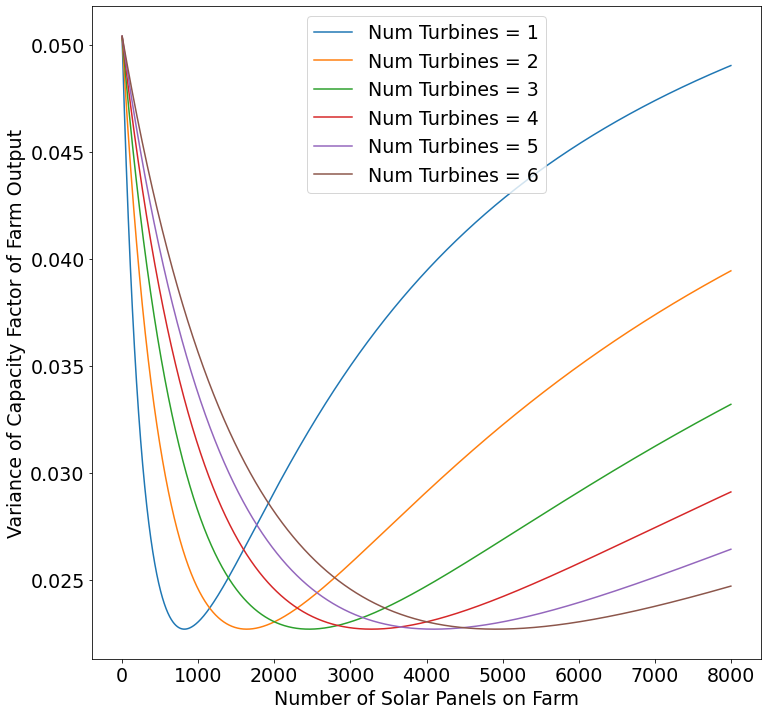

In [4]:
output = []
test_pv = range(1,8000,1)
test_turbine = range(1,7)
for i,num_turbines in enumerate(test_turbine):
    row = []
    for j, num_pv in enumerate(test_pv):
        row.append(((P_t*num_turbines)**2*var_df_t + (P_s*num_pv)**2*var_df_s+2*P_t*P_s*num_turbines*num_pv*cov_df)/(P_t*num_turbines+P_s*num_pv)**2)
    output.append(row)

fig, ax = plt.subplots(figsize = (12,12))
for i,num_turbines in enumerate(test_turbine):
    ax.plot(test_pv, output[i], label = "Num Turbines = {}".format(num_turbines))
    ax.legend()
    print("To acheive minimum variance of farm for a farm with {} turbines requires {} solar panels, (min val = {})". format(num_turbines, np.array(output[i]).argmin(), np.array(output[i]).min()))
ax.set_xlabel("Number of Solar Panels on Farm")
ax.set_ylabel("Variance of Capacity Factor of Farm Output")

Next I want to look at daily variation for both solar and wind!

At first glance, there doesn't seem to be significant complementarity between the solar and wind generation profiles on a daily scale